In [4]:
from os import listdir
from scipy import sparse

# pull X genotypes
gen_files = sorted([f for f in listdir('split_gen') if 'chr.X' in f and 'gen.npz' in f])
X_chrom = sparse.hstack([sparse.load_npz('split_gen/%s' % gen_file) for gen_file in gen_files])

# pull Y genotypes
gen_files = sorted([f for f in listdir('split_gen') if 'chr.Y' in f and 'gen.npz' in f])
Y_chrom = sparse.hstack([sparse.load_npz('split_gen/%s' % gen_file) for gen_file in gen_files])

print(X_chrom.shape, Y_chrom.shape)

In [9]:
import gzip
import numpy as np

# get indices and positions of SNPs
def get_snp_indices(chrom): 
    variant_file = 'split_gen/chr.%s.gen.variants.txt.gz' % chrom
    snp_indices = []
    snp_positions = []
    with gzip.open(variant_file, 'rt') as f:
        for i, line in enumerate(f):
            pieces = line.strip().split('\t')
            if len(pieces[3]) == 1 and len(pieces[4]) == 1 and pieces[3] != '.' and pieces[4] != '.':
                snp_indices.append(i)
                snp_positions.append(int(pieces[1]))
    return snp_indices, np.array(snp_positions)

X_snp_indices, X_snp_positions = get_snp_indices('X')
Y_snp_indices, Y_snp_positions = get_snp_indices('Y')

# Remove non-SNPs
X_chrom = X_chrom[:, X_snp_indices]
Y_chrom = Y_chrom[:, Y_snp_indices]
print(X_chrom.shape, Y_chrom.shape)

(4610, 2965581) (4610, 231075)


In [39]:
PAR1X = (60001, 2699520)
PAR2X = (154931044, 155260560)
PAR1Y = (10001, 2649520)
PAR2Y = (59034050, 59363566)

PAR1X_indices = np.where(np.logical_and(X_snp_positions >= PAR1X[0], X_snp_positions <= PAR1X[1]))[0]
PAR2X_indices = np.where(np.logical_and(X_snp_positions >= PAR2X[0], X_snp_positions <= PAR2X[1]))[0]

PAR1X_chrom = X_chrom[:, PAR1X_indices]
PAR2X_chrom = X_chrom[:, PAR2X_indices]
PAR1X_snp_positions = X_snp_positions[PAR1X_indices]
PAR2X_snp_positions = X_snp_positions[PAR2X_indices]

print(PAR1X_chrom.shape, PAR2X_chrom.shape)

(4610, 95116) (4610, 9674)


In [40]:
from collections import Counter

# pull families with sequence data
with open('split_gen/chr.X.gen.samples.txt', 'r') as f:
    sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

# pull families from ped file
families = dict()
with open('160826.ped', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, f_id, m_id = pieces[0:4]

        if child_id in sample_ids and f_id in sample_ids and m_id in sample_ids:
            if (fam_id, m_id, f_id) not in families:
                families[(fam_id, m_id, f_id)] = [m_id, f_id]
            families[(fam_id, m_id, f_id)].append(child_id)

family_to_indices = dict([(fid, [sample_id_to_index[x] for x in vs]) for fid, vs in families.items()])
family_to_index = dict([(fid, i) for i, fid in enumerate(families.keys())])

print('families with sequence data', len(families))
print('family sizes', Counter([len(x) for x in families.values()]))

families with sequence data 886
family sizes Counter({4: 436, 5: 356, 6: 57, 3: 18, 7: 13, 9: 4, 10: 1, 8: 1})


In [48]:
import random

fkey, family_index = random.choice(list(family_to_indices.items()))
print('family', fkey, family_index)

# filter out family member genotypes
ind_indices = family_to_indices[fkey]
family_PAR1X = PAR1X_chrom[ind_indices, :].A
family_PAR2X = PAR2X_chrom[ind_indices, :].A

# remove snps where the whole family is hom ref
family_PAR1X_indices = [i for i, x in enumerate(family_PAR1X.T) if tuple(x) != (0,)*m]
family_PAR1X = family_PAR1X[:, family_PAR1X_indices]
family_PAR1X_snp_positions = PAR1X_snp_positions[family_PAR1X_indices]

family_PAR2X_indices = [i for i, x in enumerate(family_PAR2X.T) if tuple(x) != (0,)*m]
family_PAR2X = family_PAR2X[:, family_PAR2X_indices]
family_PAR2X_snp_positions = PAR2X_snp_positions[family_PAR2X_indices]

print(family_PAR1X.shape, family_PAR2X.shape)

family ('AU1481', 'AU1481202', 'AU1481201') [2915, 1877, 2916, 2918, 2919]
(5, 95116) (5, 9674)


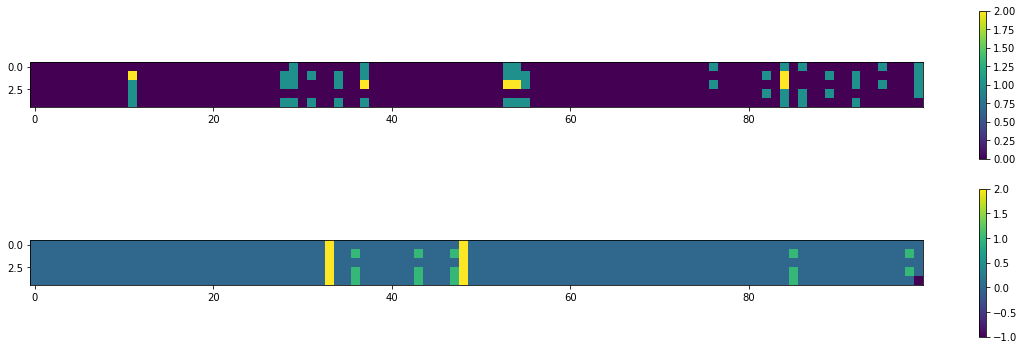

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))

plt.subplot(2, 1, 1)
plt.imshow(family_PAR1X[:, 40000:40100])
plt.colorbar()

plt.subplot(2, 1, 2)
plt.imshow(family_PAR2X[:, 4000:4100])
plt.colorbar()

plt.show()

In [ ]:
PAR1X = (60001, 2699520)
PAR2X = (154931044, 155260560)
PAR1Y = (10001, 2649520)
PAR2Y = (59034050, 59363566)